### Step 1: setup and data modeling

In [1]:
import os
import pandas as pd
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

/Users/adetsi/Desktop/projects/agrosense/venv/lib/python3.11/site-packages/mlflow/utils/requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


In [2]:
mlflow.set_tracking_uri("http://localhost:5001")

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
artifact_path = os.path.join(project_root, "mlflow", "artifacts")
artifact_uri = f"file://{artifact_path}"

experiment_name = "crop_yield_prediction"

try:
    experiment_id = mlflow.create_experiment(
        experiment_name,
        artifact_location=artifact_uri
    )
    print(f"Created new experiment with ID: {experiment_id}")
except:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
    print(f"Using existing experiment with ID: {experiment_id}")

mlflow.set_experiment(experiment_name)
print(f"Artifact location: {artifact_uri}")

Using existing experiment with ID: 1
Artifact location: file:///Users/adetsi/Desktop/projects/mlflow/artifacts


#### Loading snowflake data

In [4]:
from snowflake.connector import connect
import os
from dotenv import load_dotenv
load_dotenv()

conn = connect(
    account=os.getenv('SNOWFLAKE_ACCOUNT'),
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    database=os.getenv('SNOWFLAKE_DB'),
    warehouse=os.getenv('SNOWFLAKE_WH'),
    role=os.getenv('SNOWFLAKE_ROLE'),
    schema=os.getenv('SNOWFLAKE_SCHEMA')
)

query = "SELECT * FROM  AGROSENSE_DB.AGROSENSE_SCH.FCT_ML_TRAINING_DATASET"
df = pd.read_sql(query, conn)
conn.close()

df.head()

/var/folders/x4/rrw9x5l50yz_6clmyp_y58sm0000gn/T/ipykernel_18303/1733229511.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,TARGET_YIELD,AREA,CROP_TYPE,YEAR,AVERAGE_RAINFALL_MM_PER_YEAR,PESTICIDES_TONNES,AVG_TEMP,YIELD_EFFICIENCY,PESTICIDE_INTENSITY,YEAR_IN_DECADE,ERA
0,36613,Albania,Maize,1990,1485.0,121.0,16.37,24.655219,0.081481,0,historical
1,66667,Albania,Potatoes,1990,1485.0,121.0,16.37,44.893603,0.081481,0,historical
2,23333,Albania,"Rice, paddy",1990,1485.0,121.0,16.37,15.712458,0.081481,0,historical
3,12500,Albania,Sorghum,1990,1485.0,121.0,16.37,8.417508,0.081481,0,historical
4,7000,Albania,Soybeans,1990,1485.0,121.0,16.37,4.713805,0.081481,0,historical


#### Exploring the behavior of the data

In [5]:
df.sample(5)

,TARGET_YIELD,AREA,CROP_TYPE,YEAR,AVERAGE_RAINFALL_MM_PER_YEAR,PESTICIDES_TONNES,AVG_TEMP,YIELD_EFFICIENCY,PESTICIDE_INTENSITY,YEAR_IN_DECADE,ERA
6280,11818,Central African Republic,Potatoes,2012,1342.0,22.87,25.28,8.806259,0.017042,2,modern
10465,35875,Hungary,Wheat,2007,589.0,11178.00,11.82,60.908319,18.977929,7,historical
1797,50856,Austria,Wheat,1995,1110.0,3402.00,8.79,45.816216,3.064865,5,historical
19691,25777,Mexico,Maize,2001,758.0,31373.30,22.60,34.006596,41.389578,1,historical
6502,107224,Chile,Maize,2012,1522.0,9830.72,6.82,70.449409,6.459080,2,modern


In [6]:
df.shape

(28242, 11)

In [7]:
df.isna().any().sum()

0

In [8]:
print(df.describe())

        TARGET_YIELD          YEAR  AVERAGE_RAINFALL_MM_PER_YEAR  \
count   28242.000000  28242.000000                   28242.00000   
mean    77053.332094   2001.544296                    1149.05598   
std     84956.612897      7.051905                     709.81215   
min        50.000000   1990.000000                      51.00000   
25%     19919.250000   1995.000000                     593.00000   
50%     38295.000000   2001.000000                    1083.00000   
75%    104676.750000   2008.000000                    1668.00000   
max    501412.000000   2013.000000                    3240.00000   

       PESTICIDES_TONNES      AVG_TEMP  YIELD_EFFICIENCY  PESTICIDE_INTENSITY  \
count       28242.000000  28242.000000      28242.000000         28242.000000   
mean        37076.909344     20.542627        136.310738            36.344838   
std         59958.784665      6.312051        392.177079            42.976550   
min             0.040000      1.300000          0.072359       

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TARGET_YIELD                  28242 non-null  int64  
 1   AREA                          28242 non-null  object 
 2   CROP_TYPE                     28242 non-null  object 
 3   YEAR                          28242 non-null  int64  
 4   AVERAGE_RAINFALL_MM_PER_YEAR  28242 non-null  float64
 5   PESTICIDES_TONNES             28242 non-null  float64
 6   AVG_TEMP                      28242 non-null  float64
 7   YIELD_EFFICIENCY              28242 non-null  float64
 8   PESTICIDE_INTENSITY           28242 non-null  float64
 9   YEAR_IN_DECADE                28242 non-null  int64  
 10  ERA                           28242 non-null  object 
dtypes: float64(5), int64(3), object(3)
memory usage: 2.4+ MB


In [10]:
print("Unique AREA Values:\n", df['AREA'].unique())
print("Number of Unique AREA Values:", df['AREA'].nunique(), "\n")

print("Unique CROP_TYPE Values:\n", df['CROP_TYPE'].unique())
print("Number of Unique CROP_TYPE Values:", df['CROP_TYPE'].nunique(), "\n")

print("Unique ERA Values:\n", df['ERA'].unique())
print("Number of Unique ERA Values:", df['ERA'].nunique(), "\n")

Unique AREA Values:
 ['Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Belarus' 'Belgium'
 'Botswana' 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cameroon'
 'Canada' 'Central African Republic' 'Chile' 'Colombia' 'Croatia'
 'Denmark' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Eritrea'
 'Estonia' 'Finland' 'France' 'Germany' 'Ghana' 'Greece' 'Guatemala'
 'Guinea' 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'India' 'Indonesia' 'Iraq'
 'Ireland' 'Italy' 'Jamaica' 'Japan' 'Kazakhstan' 'Kenya' 'Latvia'
 'Lebanon' 'Lesotho' 'Libya' 'Lithuania' 'Madagascar' 'Malawi' 'Malaysia'
 'Mali' 'Mauritania' 'Mauritius' 'Mexico' 'Montenegro' 'Morocco'
 'Mozambique' 'Namibia' 'Nepal' 'Netherlands' 'New Zealand' 'Nicaragua'
 'Niger' 'Norway' 'Pakistan' 'Papua New Guinea' 'Peru' 'Poland' 'Portugal'
 'Qatar' 'Romania' 'Rwanda' 'Saudi Arabia' 'Senegal' 'Slovenia'
 'South Africa' 'Spain' 'Sri Lanka' 'Sudan' 'Suriname' 'Sweden'
 'Swi

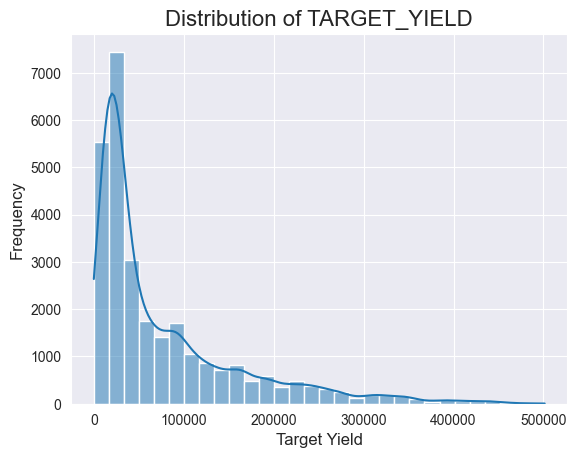

In [11]:
sns.histplot(df['TARGET_YIELD'], kde=True, bins=30)

plt.title("Distribution of TARGET_YIELD", fontsize=16)
plt.xlabel("Target Yield", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

### Step 2: Feature Engineering and Preprocessing

In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

df_model = df.copy()

X = df_model.drop(['TARGET_YIELD'], axis=1)
y = df_model['TARGET_YIELD']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

label_encoders = {}
categorical_cols = ['AREA','CROP_TYPE','ERA']

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"\n'{col} encoded': {le.classes_} unique values")

Features shape: (28242, 10)
Target shape: (28242,)

'AREA encoded': ['Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Belarus' 'Belgium'
 'Botswana' 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cameroon'
 'Canada' 'Central African Republic' 'Chile' 'Colombia' 'Croatia'
 'Denmark' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Eritrea'
 'Estonia' 'Finland' 'France' 'Germany' 'Ghana' 'Greece' 'Guatemala'
 'Guinea' 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'India' 'Indonesia' 'Iraq'
 'Ireland' 'Italy' 'Jamaica' 'Japan' 'Kazakhstan' 'Kenya' 'Latvia'
 'Lebanon' 'Lesotho' 'Libya' 'Lithuania' 'Madagascar' 'Malawi' 'Malaysia'
 'Mali' 'Mauritania' 'Mauritius' 'Mexico' 'Montenegro' 'Morocco'
 'Mozambique' 'Namibia' 'Nepal' 'Netherlands' 'New Zealand' 'Nicaragua'
 'Niger' 'Norway' 'Pakistan' 'Papua New Guinea' 'Peru' 'Poland' 'Portugal'
 'Qatar' 'Romania' 'Rwanda' 'Saudi Arabia' 'Senegal' 'Slovenia'
 'South Africa' 'Spain

### Step 3: Train-Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

Training data shape: (22593, 10)
Testing data shape: (5649, 10)


In [14]:
X_train_scaled

array([[-1.06269025,  0.21913139,  0.48627038, ..., -0.83647846,
         0.31962803, -0.46586797],
       [-0.16837445,  0.59818624, -1.3559997 , ...,  0.67303524,
        -0.70057767, -0.46586797],
       [-1.43532184, -1.67614287, -0.64743428, ..., -0.83978692,
         0.99976515, -0.46586797],
       ...,
       [-1.54711131, -0.53897832, -1.49771279, ..., -0.06972196,
        -1.04064623, -0.46586797],
       [-0.01932182,  0.97724109, -0.78914737, ...,  1.2391102 ,
         0.65969659, -0.46586797],
       [ 1.13583609,  0.97724109, -0.36400812, ..., -0.42845852,
         1.67990228, -0.46586797]])

### Step 4: Train Model with MLflow Tracking

In [15]:
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

with mlflow.start_run(run_name='random_forest_baseline'):
    params = {
        'n_estimators': 100,
        'max_depth': 20,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'random_state': 42,
        'n_jobs': -1
    }
    mlflow.log_params(params)

    print("Training Random Forest model...")
    rf_model = RandomForestRegressor(**params)
    rf_model.fit(X_train_scaled, y_train)

    y_pred_train = rf_model.predict(X_train_scaled)
    y_pred_test = rf_model.predict(X_test_scaled)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    mlflow.log_metric('train_mse', train_rmse)
    mlflow.log_metric('test_mse', test_rmse)
    mlflow.log_metric('train_mae', train_mae)
    mlflow.log_metric('test_mae', test_mae)
    mlflow.log_metric('train_r2', train_r2)

    mlflow.sklearn.log_model(rf_model, artifact_path="random_forest_model", registered_model_name="RandomForestRegressorModel")

    print("\n" + "="*50)
    print("MODEL PERFORMANCE")
    print("="*50)
    print(f"Train RMSE: {train_rmse:,.2f}")
    print(f"Test RMSE:  {test_rmse:,.2f}")
    print(f"Train MAE:  {train_mae:,.2f}")
    print(f"Test MAE:   {test_mae:,.2f}")
    print(f"Train R²:   {train_r2:.4f}")
    print(f"Test R²:    {test_r2:.4f}")
    print("="*50)

    run_id = mlflow.active_run().info.run_id
    print(f"Run ID: {run_id}")

Training Random Forest model...


Registered model 'RandomForestRegressorModel' already exists. Creating a new version of this model...
2025/10/25 14:47:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestRegressorModel, version 5



MODEL PERFORMANCE
Train RMSE: 1,317.71
Test RMSE:  2,990.47
Train MAE:  284.11
Test MAE:   631.71
Train R²:   0.9998
Test R²:    0.9988
Run ID: 5e221d386f1e454abe70b9c02e3c147f


Created version '5' of model 'RandomForestRegressorModel'.


#### Results
- We're getting exceptional results of 99.9% r2 - which means the model explain 99.9% of the variability in the dataset,
- However, this is too good to be true for a baseline model, hence we need to investigate the validity of this results
- Who knows there may be a data leakage somewhere

### Step 5: Model Analysis & Visualization

In [17]:
# Create predictions DataFrame for analysis
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test,
    'Error': y_test - y_pred_test,
    'Absolute_Error': np.abs(y_test - y_pred_test),
    'Percentage_Error': np.abs((y_test - y_pred_test) / y_test) * 100
})

# Add back some categorical info for analysis
crop_type_class_to_index = {label: idx for idx, label in enumerate(label_encoders['CROP_TYPE'].classes_)}
area_class_to_index = {label: idx for idx, label in enumerate(label_encoders['AREA'].classes_)}

crop_type_index_to_class = {v: k for k, v in crop_type_class_to_index.items()}
area_index_to_class = {v: k for k, v in area_class_to_index.items()}

results_df['CROP_TYPE'] = X_test['CROP_TYPE'].map(crop_type_index_to_class).values
results_df['AREA'] = X_test['AREA'].map(area_index_to_class).values


print("Prediction Analysis:")
print(f"Mean Absolute Percentage Error: {results_df['Percentage_Error'].mean():.2f}%")
print(f"Median Absolute Percentage Error: {results_df['Percentage_Error'].median():.2f}%")
print("\nWorst Predictions:")
print(results_df.nlargest(5, 'Absolute_Error')[['Actual', 'Predicted', 'Error', 'CROP_TYPE', 'AREA']])

Prediction Analysis:
Mean Absolute Percentage Error: 0.76%
Median Absolute Percentage Error: 0.14%

Worst Predictions:
       Actual      Predicted         Error CROP_TYPE         AREA
2075   255556  190773.265500  64782.734500  Potatoes      Bahrain
199    292806  231429.123262  61376.876738  Potatoes      Algeria
20781  363561  306491.545274  57069.454726  Potatoes      Morocco
26159  457778  402132.679078  55645.320922  Potatoes  Switzerland
8874   468991  413768.164103  55222.835897  Potatoes       France


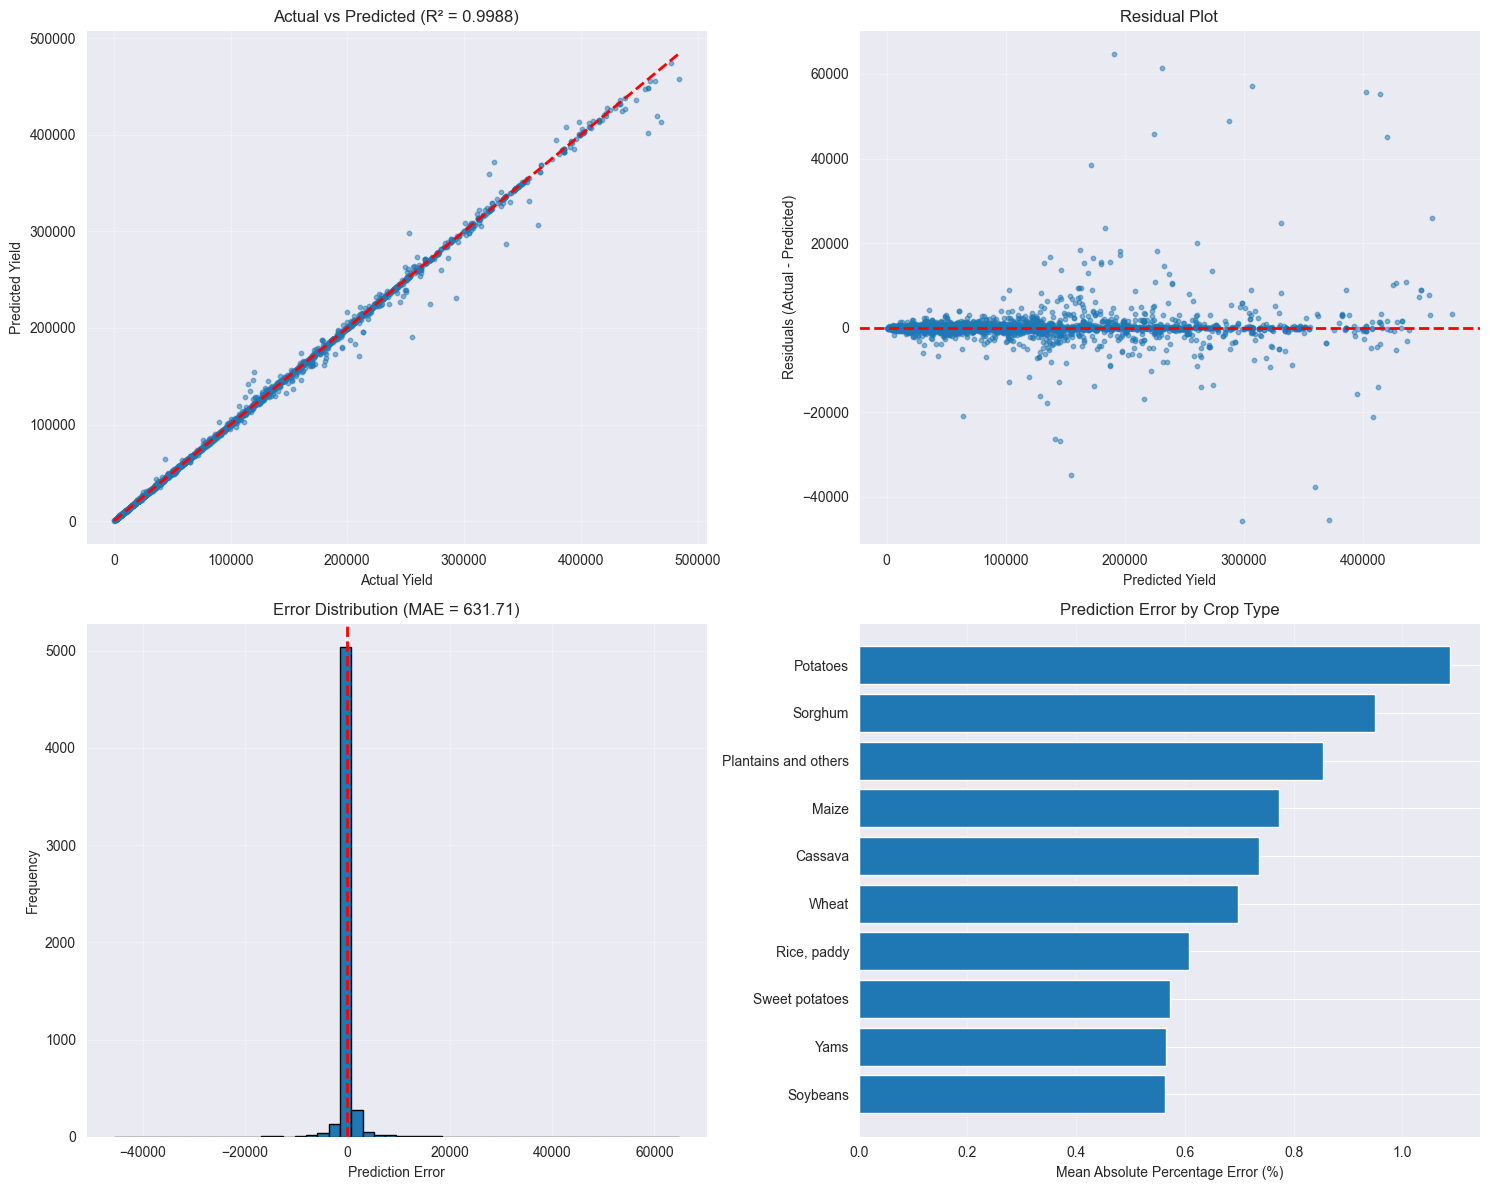

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.5, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Yield')
axes[0, 0].set_ylabel('Predicted Yield')
axes[0, 0].set_title(f'Actual vs Predicted (R² = {test_r2:.4f})')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals plot
axes[0, 1].scatter(y_pred_test, results_df['Error'], alpha=0.5, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Yield')
axes[0, 1].set_ylabel('Residuals (Actual - Predicted)')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Error distribution
axes[1, 0].hist(results_df['Error'], bins=50, edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Prediction Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Error Distribution (MAE = {test_mae:.2f})')
axes[1, 0].grid(True, alpha=0.3)

# 4. Percentage error by crop type
crop_errors = results_df.groupby('CROP_TYPE')['Percentage_Error'].mean().sort_values()
axes[1, 1].barh(crop_errors.index, crop_errors.values)
axes[1, 1].set_xlabel('Mean Absolute Percentage Error (%)')
axes[1, 1].set_title('Prediction Error by Crop Type')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


Feature Importance:
                        Feature  Importance
6              YIELD_EFFICIENCY    0.736341
3  AVERAGE_RAINFALL_MM_PER_YEAR    0.257609
5                      AVG_TEMP    0.001525
4             PESTICIDES_TONNES    0.001261
7           PESTICIDE_INTENSITY    0.001076
0                          AREA    0.000799
2                          YEAR    0.000719
1                     CROP_TYPE    0.000458
8                YEAR_IN_DECADE    0.000175
9                           ERA    0.000037


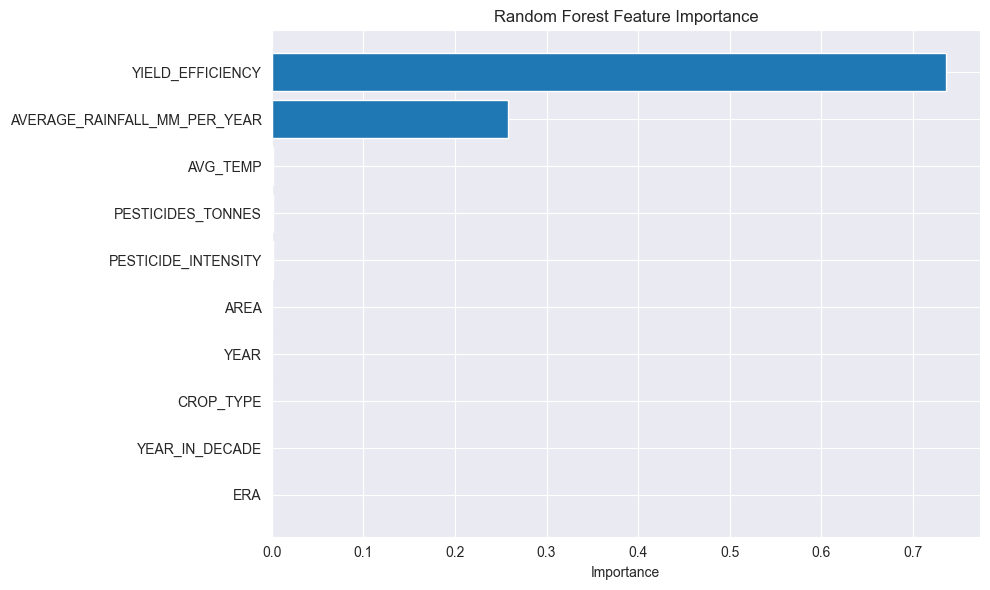

In [19]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()